# Workflow Interface 101: Quickstart
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/intel/openfl/blob/develop/openfl-tutorials/experimental/Workflow_Interface_101_MNIST.ipynb)

Welcome to the first OpenFL Experimental Workflow Interface tutorial! This notebook introduces the API to get up and running with your first horizontal federated learning workflow. This work has the following goals:

- Simplify the federated workflow representation
- Help users better understand the steps in federated learning (weight extraction, compression, etc.)
- Designed to maintain data privacy
- Aims for syntatic consistency with the Netflix MetaFlow project. Infrastructure reuse where possible.

# What is it?

The workflow interface is a new way of composing federated learning expermients with OpenFL. It was borne through conversations with researchers and existing users who had novel use cases that didn't quite fit the standard horizontal federated learning paradigm. 

# Getting Started

First we start by installing the necessary dependencies for the workflow interface

In [1]:
# !pip install git+https://github.com/intel/openfl.git
!pip install -r ../requirements_workflow_interface.txt

# Uncomment this if running in Google Colab
#!pip install -r https://raw.githubusercontent.com/intel/openfl/develop/openfl-tutorials/experimental/requirements_workflow_interface.txt
#import os
#os.environ["USERNAME"] = "colab"

We begin with the quintessential example of a small pytorch CNN model trained on the MNIST dataset. Let's start define our dataloaders, model, optimizer, and some helper functions like we would for any other deep learning experiment

In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import torchvision
import numpy as np

n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

# mnist_train = torchvision.datasets.MNIST('files/', train=True, download=True,
#                              transform=torchvision.transforms.Compose([
#                                torchvision.transforms.ToTensor(),
#                                torchvision.transforms.Normalize(
#                                  (0.1307,), (0.3081,))
#                              ]))

# mnist_test = torchvision.datasets.MNIST('files/', train=False, download=True,
#                              transform=torchvision.transforms.Compose([
#                                torchvision.transforms.ToTensor(),
#                                torchvision.transforms.Normalize(
#                                  (0.1307,), (0.3081,))
#                              ]))

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)
    
def inference(network,test_loader):
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
      for data, target in test_loader:
        output = network(data)
        test_loss += F.nll_loss(output, target, size_average=False).item()
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
      test_loss, correct, len(test_loader.dataset),
      100. * correct / len(test_loader.dataset)))
    accuracy = float(correct / len(test_loader.dataset))
    return accuracy

/home/parth-wsl/miniconda3/envs/env_collaborator_private_attribute_deplayed_execution/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Next we import the `FLSpec`, `LocalRuntime`, and placement decorators.

- `FLSpec` – Defines the flow specification. User defined flows are subclasses of this.
- `Runtime` – Defines where the flow runs, infrastructure for task transitions (how information gets sent). The `LocalRuntime` runs the flow on a single node.
- `aggregator/collaborator` - placement decorators that define where the task will be assigned

In [3]:
from copy import deepcopy

from openfl.experimental.interface import FLSpec, Aggregator, Collaborator
from openfl.experimental.runtime import LocalRuntime
from openfl.experimental.placement import aggregator, collaborator


def FedAvg(models):
    new_model = models[0]
    state_dicts = [model.state_dict() for model in models]
    state_dict = new_model.state_dict()
    for key in models[1].state_dict():
        state_dict[key] = np.sum([state[key] for state in state_dicts],axis=0) / len(models)
    new_model.load_state_dict(state_dict)
    return new_model



Now we come to the flow definition. The OpenFL Workflow Interface adopts the conventions set by Metaflow, that every workflow begins with `start` and concludes with the `end` task. The aggregator begins with an optionally passed in model and optimizer. The aggregator begins the flow with the `start` task, where the list of collaborators is extracted from the runtime (`self.collaborators = self.runtime.collaborators`) and is then used as the list of participants to run the task listed in `self.next`, `aggregated_model_validation`. The model, optimizer, and anything that is not explicitly excluded from the next function will be passed from the `start` function on the aggregator to the `aggregated_model_validation` task on the collaborator. Where the tasks run is determined by the placement decorator that precedes each task definition (`@aggregator` or `@collaborator`). Once each of the collaborators (defined in the runtime) complete the `aggregated_model_validation` task, they pass their current state onto the `train` task, from `train` to `local_model_validation`, and then finally to `join` at the aggregator. It is in `join` that an average is taken of the model weights, and the next round can begin.

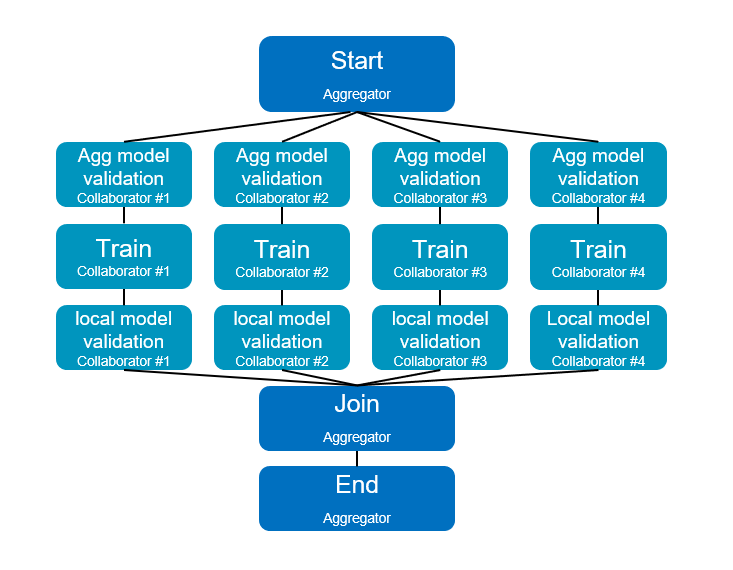

In [4]:
class FederatedFlow(FLSpec):

    def __init__(self, model = None, optimizer = None, rounds=3, **kwargs):
        super().__init__(**kwargs)
        if model is not None:
            self.model = model
            self.optimizer = optimizer
        else:
            self.model = Net()
            self.optimizer = optim.SGD(self.model.parameters(), lr=learning_rate,
                                   momentum=momentum)
        self.rounds = rounds

    @aggregator
    def start(self):
        print(f'Performing initialization for model')
        self.collaborators = self.runtime.collaborators
        self.private = 10
        self.current_round = 0
        self.next(self.aggregated_model_validation,foreach='collaborators',exclude=['private'])

    @collaborator
    def aggregated_model_validation(self):
        print(f'Performing aggregated model validation for collaborator {self.input}')
        self.agg_validation_score = inference(self.model,self.test_loader)
        print(f'{self.input} value of {self.agg_validation_score}')
        self.next(self.train)

    @collaborator
    def train(self):
        self.model.train()
        self.optimizer = optim.SGD(self.model.parameters(), lr=learning_rate,
                                   momentum=momentum)
        train_losses = []
        for batch_idx, (data, target) in enumerate(self.train_loader):
          self.optimizer.zero_grad()
          output = self.model(data)
          loss = F.nll_loss(output, target)
          loss.backward()
          self.optimizer.step()
          if batch_idx % log_interval == 0:
            print('Train Epoch: 1 [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
               batch_idx * len(data), len(self.train_loader.dataset),
              100. * batch_idx / len(self.train_loader), loss.item()))
            self.loss = loss.item()
            torch.save(self.model.state_dict(), 'model.pth')
            torch.save(self.optimizer.state_dict(), 'optimizer.pth')
        self.training_completed = True
        self.next(self.local_model_validation)

    @collaborator
    def local_model_validation(self):
        self.local_validation_score = inference(self.model,self.test_loader)
        print(f'Doing local model validation for collaborator {self.input}: {self.local_validation_score}')
        self.next(self.join, exclude=['training_completed'])

    @aggregator
    def join(self,inputs):
        self.average_loss = sum(input.loss for input in inputs)/len(inputs)
        self.aggregated_model_accuracy = sum(input.agg_validation_score for input in inputs)/len(inputs)
        self.local_model_accuracy = sum(input.local_validation_score for input in inputs)/len(inputs)
        print(f'Average aggregated model validation values = {self.aggregated_model_accuracy}')
        print(f'Average training loss = {self.average_loss}')
        print(f'Average local model validation values = {self.local_model_accuracy}')
        self.model = FedAvg([input.model for input in inputs])
        self.optimizer = [input.optimizer for input in inputs][0]
        self.current_round += 1
        if self.current_round < self.rounds:
            self.next(self.aggregated_model_validation, foreach='collaborators', exclude=['private'])
        else:
            self.next(self.end)
        
    @aggregator
    def end(self):
        print(f'This is the end of the flow')  

Aggregator step "start" registered
Collaborator step "aggregated_model_validation" registered
Collaborator step "train" registered
Collaborator step "local_model_validation" registered
Aggregator step "join" registered
Aggregator step "end" registered


You'll notice in the `FederatedFlow` definition above that there were certain attributes that the flow was not initialized with, namely the `train_loader` and `test_loader` for each of the collaborators. These are **private_attributes** that are exposed only throught he runtime. Each participant has it's own set of private attributes: a dictionary where the key is the attribute name, and the value is the object that will be made accessible through that participant's task. 

Below, we segment shards of the MNIST dataset for **four collaborators**: Portland, Seattle, Chandler, and Portland. Each has their own slice of the dataset that's accessible via the `train_loader` or `test_loader` attribute. Note that the private attributes are flexible, and you can choose to pass in a completely different type of object to any of the collaborators or aggregator (with an arbitrary name). These private attributes will always be filtered out of the current state when transfering from collaborator to aggregator, or vice versa.  

In [5]:
# Setup participants
aggregator = Aggregator()
aggregator.private_attributes = {}

# Setup collaborators with private attributes
collaborator_names = ['Portland', 'Seattle', 'Chandler','Bangalore']
collaborators = [Collaborator(name=name, shard_descriptor_path="mnist_shard_descriptor") for name in collaborator_names]
# for idx, collaborator in enumerate(collaborators):
#     local_train = deepcopy(mnist_train)
#     local_test = deepcopy(mnist_test)
#     local_train.data = mnist_train.data[idx::len(collaborators)]
#     local_train.targets = mnist_train.targets[idx::len(collaborators)]
#     local_test.data = mnist_test.data[idx::len(collaborators)]
#     local_test.targets = mnist_test.targets[idx::len(collaborators)]
#     collaborator.private_attributes = {
#             'train_loader': torch.utils.data.DataLoader(local_train,batch_size=batch_size_train, shuffle=True),
#             'test_loader': torch.utils.data.DataLoader(local_test,batch_size=batch_size_train, shuffle=True)
#     }

local_runtime = LocalRuntime(aggregator=aggregator, collaborators=collaborators, backend='single_process')
print(f'Local runtime collaborators = {local_runtime.collaborators}')

Local runtime collaborators = ['Portland', 'Seattle', 'Chandler', 'Bangalore']


Now that we have our flow and runtime defined, let's run the experiment! 

In [6]:
model = None
best_model = None
optimizer = None
flflow = FederatedFlow(model,optimizer)
flflow.runtime = local_runtime
flflow.run()


Calling start
Performing initialization for model
Sending state from aggregator to collaborators

Calling aggregated_model_validation
Performing aggregated model validation for collaborator Portland


/tmp/ipykernel_2364/3322957144.py:49: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
/home/parth-wsl/miniconda3/envs/env_collaborator_private_attribute_deplayed_execution/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3282, Accuracy: 1696/15000 (11%)

Portland value of 0.113066665828228

Calling train
Train Epoch: 1 [0/15000 (0%)]	Loss: 2.370591
Train Epoch: 1 [640/15000 (4%)]	Loss: 2.265008
Train Epoch: 1 [1280/15000 (9%)]	Loss: 2.300407
Train Epoch: 1 [1920/15000 (13%)]	Loss: 2.249448
Train Epoch: 1 [2560/15000 (17%)]	Loss: 2.251498
Train Epoch: 1 [3200/15000 (21%)]	Loss: 2.267806
Train Epoch: 1 [3840/15000 (26%)]	Loss: 2.201275
Train Epoch: 1 [4480/15000 (30%)]	Loss: 2.181914
Train Epoch: 1 [5120/15000 (34%)]	Loss: 2.115410
Train Epoch: 1 [5760/15000 (38%)]	Loss: 2.086648
Train Epoch: 1 [6400/15000 (43%)]	Loss: 1.970716
Train Epoch: 1 [7040/15000 (47%)]	Loss: 1.829771
Train Epoch: 1 [7680/15000 (51%)]	Loss: 1.932815
Train Epoch: 1 [8320/15000 (55%)]	Loss: 1.816920
Train Epoch: 1 [8960/15000 (60%)]	Loss: 1.799353
Train Epoch: 1 [9600/15000 (64%)]	Loss: 1.678414
Train Epoch: 1 [10240/15000 (68%)]	Loss: 1.542434
Train Epoch: 1 [10880/15000 (72%)]	Loss: 1.900784
Train Epoch: 1

/home/parth-wsl/miniconda3/envs/env_collaborator_private_attribute_deplayed_execution/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/parth-wsl/miniconda3/envs/env_collaborator_private_attribute_deplayed_execution/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to d

Sending state from aggregator to collaborators

Calling aggregated_model_validation
Performing aggregated model validation for collaborator Portland

Test set: Avg. loss: 0.7785, Accuracy: 12311/15000 (82%)

Portland value of 0.8207333087921143

Calling train
Train Epoch: 1 [0/15000 (0%)]	Loss: 1.036670
Train Epoch: 1 [640/15000 (4%)]	Loss: 0.987077
Train Epoch: 1 [1280/15000 (9%)]	Loss: 0.955510
Train Epoch: 1 [1920/15000 (13%)]	Loss: 1.221339
Train Epoch: 1 [2560/15000 (17%)]	Loss: 1.034102
Train Epoch: 1 [3200/15000 (21%)]	Loss: 0.982033
Train Epoch: 1 [3840/15000 (26%)]	Loss: 0.796928
Train Epoch: 1 [4480/15000 (30%)]	Loss: 0.822490
Train Epoch: 1 [5120/15000 (34%)]	Loss: 1.147250
Train Epoch: 1 [5760/15000 (38%)]	Loss: 0.996468
Train Epoch: 1 [6400/15000 (43%)]	Loss: 0.869048
Train Epoch: 1 [7040/15000 (47%)]	Loss: 0.904159
Train Epoch: 1 [7680/15000 (51%)]	Loss: 1.089286
Train Epoch: 1 [8320/15000 (55%)]	Loss: 0.977218
Train Epoch: 1 [8960/15000 (60%)]	Loss: 0.879150
Train Epoch:

Now that the flow has completed, let's get the final model and accuracy:

In [7]:
print(f'Sample of the final model weights: {flflow.model.state_dict()["conv1.weight"][0]}')

print(f'\nFinal aggregated model accuracy for {flflow.rounds} rounds of training: {flflow.aggregated_model_accuracy}')

Sample of the final model weights: tensor([[[ 0.1227, -0.0904, -0.0769,  0.0429, -0.2164],
         [ 0.1655, -0.0140,  0.0998,  0.0272, -0.0127],
         [ 0.1205,  0.0761,  0.1288, -0.0149,  0.0356],
         [ 0.0162,  0.0724,  0.0472,  0.2230,  0.1104],
         [-0.0860, -0.1325, -0.0498, -0.0903, -0.0458]]])

Final aggregated model accuracy for 3 rounds of training: 0.9011833369731903


We can get the final model, and all other aggregator attributes after the flow completes. But what if there's an intermediate model task and its specific output that we want to look at in detail? This is where **checkpointing** and reuse of Metaflow tooling come in handy.

Let's make a tweak to the flow object, and run the experiment one more time (we can even use our previous model / optimizer as a base for the experiment)

In [8]:
flflow2 = FederatedFlow(model=flflow.model,optimizer=flflow.optimizer,checkpoint=True)
flflow2.runtime = local_runtime
flflow2.run()

Created flow FederatedFlow

Calling start
Performing initialization for model
Saving data artifacts for start
Saved data artifacts for start
Sending state from aggregator to collaborators

Calling aggregated_model_validation
Performing aggregated model validation for collaborator Portland


/tmp/ipykernel_2364/3322957144.py:49: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 0.3165, Accuracy: 13602/15000 (91%)

Portland value of 0.9067999720573425
Saving data artifacts for aggregated_model_validation
Saved data artifacts for aggregated_model_validation

Calling train
Train Epoch: 1 [0/15000 (0%)]	Loss: 0.634003
Train Epoch: 1 [640/15000 (4%)]	Loss: 0.505847
Train Epoch: 1 [1280/15000 (9%)]	Loss: 0.639727
Train Epoch: 1 [1920/15000 (13%)]	Loss: 0.457166
Train Epoch: 1 [2560/15000 (17%)]	Loss: 0.742236
Train Epoch: 1 [3200/15000 (21%)]	Loss: 0.596758
Train Epoch: 1 [3840/15000 (26%)]	Loss: 0.683500
Train Epoch: 1 [4480/15000 (30%)]	Loss: 0.797591
Train Epoch: 1 [5120/15000 (34%)]	Loss: 0.702422
Train Epoch: 1 [5760/15000 (38%)]	Loss: 0.405386
Train Epoch: 1 [6400/15000 (43%)]	Loss: 0.459723
Train Epoch: 1 [7040/15000 (47%)]	Loss: 0.725383
Train Epoch: 1 [7680/15000 (51%)]	Loss: 0.848863
Train Epoch: 1 [8320/15000 (55%)]	Loss: 0.468560
Train Epoch: 1 [8960/15000 (60%)]	Loss: 0.628713
Train Epoch: 1 [9600/15000 (64%)]	Loss: 0.625059
Train

Now that the flow is complete, let's dig into some of the information captured along the way

In [9]:
run_id = flflow2._run_id

In [10]:
import metaflow

In [11]:
from metaflow import Metaflow, Flow, Task, Step

In [12]:
m = Metaflow()
list(m)

[Flow('AggregatorValidationFlow'),
 Flow('FederatedFlow'),
 Flow('CyclicLearningFlow'),
 Flow('MultipleCollabFlow'),
 Flow('FedProxFlow'),
 Flow('FederatedFlow_MNIST_Watermarking')]

For existing users of Metaflow, you'll notice this is the same way you would examine a flow after completion. Let's look at the latest run that generated some results:

In [13]:
f = Flow('FederatedFlow').latest_run

In [14]:
f

Run('FederatedFlow/1679816484190126')

And its list of steps

In [15]:
list(f)

[Step('FederatedFlow/1679816484190126/end'),
 Step('FederatedFlow/1679816484190126/join'),
 Step('FederatedFlow/1679816484190126/local_model_validation'),
 Step('FederatedFlow/1679816484190126/train'),
 Step('FederatedFlow/1679816484190126/aggregated_model_validation'),
 Step('FederatedFlow/1679816484190126/start')]

This matches the list of steps executed in the flow, so far so good...

In [16]:
s = Step(f'FederatedFlow/{run_id}/train')

In [17]:
s

Step('FederatedFlow/1679816484190126/train')

In [18]:
list(s)

[Task('FederatedFlow/1679816484190126/train/38'),
 Task('FederatedFlow/1679816484190126/train/35'),
 Task('FederatedFlow/1679816484190126/train/32'),
 Task('FederatedFlow/1679816484190126/train/29'),
 Task('FederatedFlow/1679816484190126/train/25'),
 Task('FederatedFlow/1679816484190126/train/22'),
 Task('FederatedFlow/1679816484190126/train/19'),
 Task('FederatedFlow/1679816484190126/train/16'),
 Task('FederatedFlow/1679816484190126/train/12'),
 Task('FederatedFlow/1679816484190126/train/9'),
 Task('FederatedFlow/1679816484190126/train/6'),
 Task('FederatedFlow/1679816484190126/train/3')]

Now we see **12** steps: **4** collaborators each performed **3** rounds of model training  

In [19]:
t = Task(f'FederatedFlow/{run_id}/train/9')

In [20]:
t

Task('FederatedFlow/1679816484190126/train/9')

Now let's look at the data artifacts this task generated

In [21]:
t.data

<MetaflowData: train_loader, agg_validation_score, model, test_loader, loss, collaborators, rounds, training_completed, input, optimizer, current_round>

In [22]:
t.data.input

'Chandler'

Now let's look at its log output (stdout)

In [23]:
print(t.stdout)

Train Epoch: 1 [0/15000 (0%)]	Loss: 0.506418
Train Epoch: 1 [640/15000 (4%)]	Loss: 0.649432
Train Epoch: 1 [1280/15000 (9%)]	Loss: 0.523684
Train Epoch: 1 [1920/15000 (13%)]	Loss: 0.603944
Train Epoch: 1 [2560/15000 (17%)]	Loss: 0.653826
Train Epoch: 1 [3200/15000 (21%)]	Loss: 0.573081
Train Epoch: 1 [3840/15000 (26%)]	Loss: 0.629217
Train Epoch: 1 [4480/15000 (30%)]	Loss: 0.472972
Train Epoch: 1 [5120/15000 (34%)]	Loss: 0.525911
Train Epoch: 1 [5760/15000 (38%)]	Loss: 0.505193
Train Epoch: 1 [6400/15000 (43%)]	Loss: 0.491993
Train Epoch: 1 [7040/15000 (47%)]	Loss: 0.729077
Train Epoch: 1 [7680/15000 (51%)]	Loss: 0.362829
Train Epoch: 1 [8320/15000 (55%)]	Loss: 0.363965
Train Epoch: 1 [8960/15000 (60%)]	Loss: 0.717617
Train Epoch: 1 [9600/15000 (64%)]	Loss: 0.665190
Train Epoch: 1 [10240/15000 (68%)]	Loss: 0.496521
Train Epoch: 1 [10880/15000 (72%)]	Loss: 0.460710
Train Epoch: 1 [11520/15000 (77%)]	Loss: 0.601601
Train Epoch: 1 [12160/15000 (81%)]	Loss: 0.456260
Train Epoch: 1 [12800/1

And any error logs? (stderr)

In [24]:
print(t.stderr)

# Congratulations!
Now that you've completed your first workflow interface quickstart notebook, see some of the more advanced things you can do in our [other tutorials](broken_link), including:

- Using the LocalRuntime Ray Backend for dedicated GPU access
- Vertical Federated Learning
- Model Watermarking
- Differential Privacy
- And More!